Universidad Galileo

Text Mining and Image Recognition

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Proyecto Final - Pipeline Completo

Este proyecto consiste en la elaboración de un pipeline de transformaciones que permita estimar el número de hojas en una área determinada cubierta por grama. Para este proyecto se utilizan librerias de Computer Vision para hacer las transformaciones correspondientes y el cálculo de la estimación.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

### Imagen Original

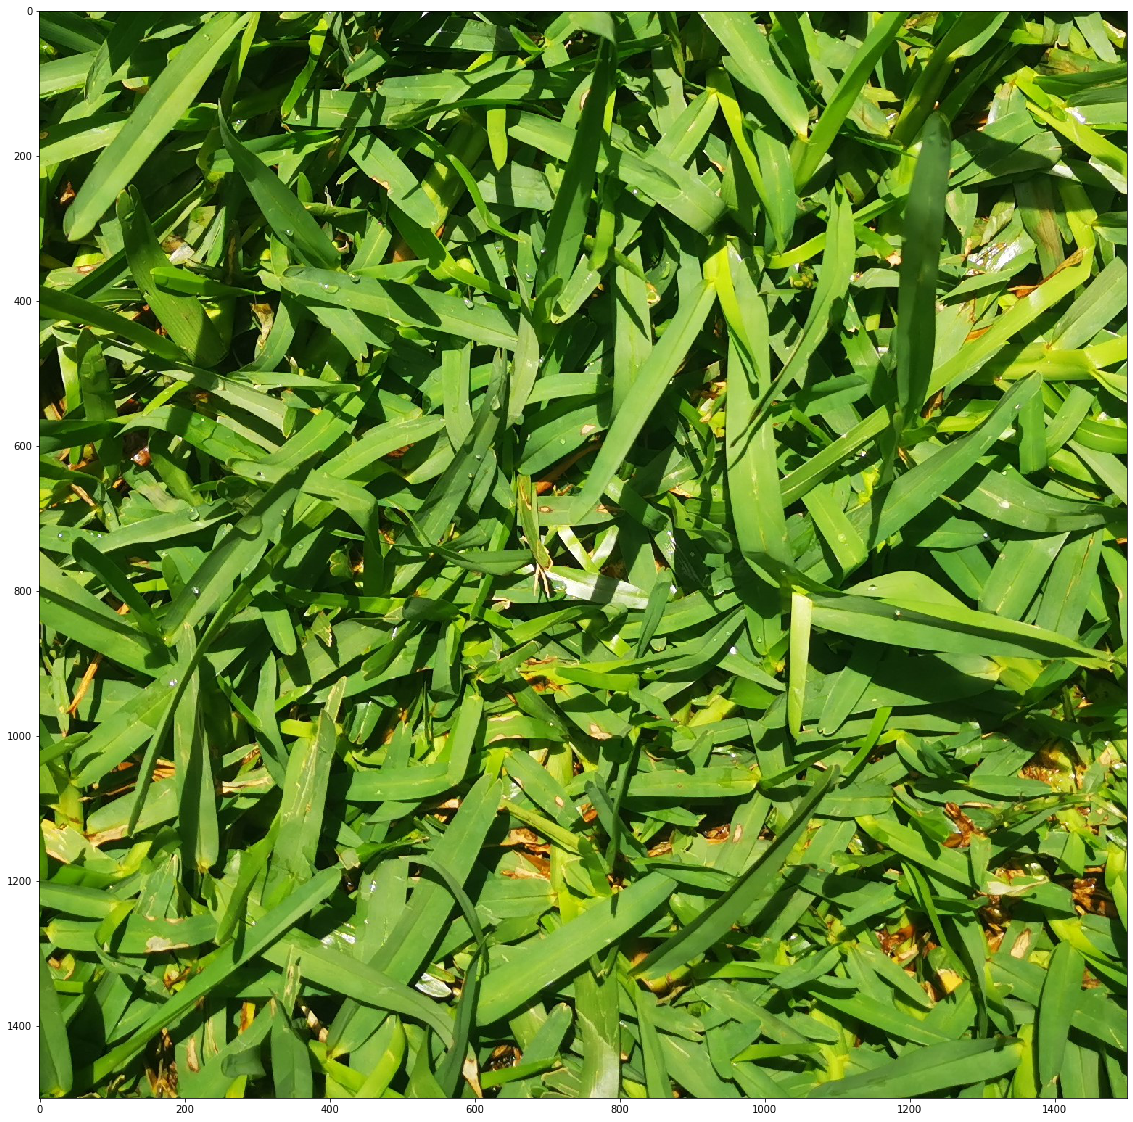

In [3]:
path ="./imagenes/grama1copia.jpg"
image = cv2.imread(path)
image = cv2.resize(image,(1500,1500))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,20))
plt.imshow(image)

In [170]:
def tallos_grama(path, numero_particiones, medida_foto, medida_campo):
    
    # Lectura y Grid de Imagenes
    #----------------------------------------------
    def separacion_imagenes(im, ancho, alto):
    
        w, h = im.size

        w_step = w / ancho
        h_step = h / alto

        cuadros = []
        for y in range(0, alto):
            for x in range(0, ancho):
                x1 = x * w_step
                y1 = y * h_step
                x2 = x1 + w_step
                y2 = y1 + h_step
                t = im.crop((x1, y1, x2, y2))
                cuadros.append(t)

        return cuadros

    filas = columnas = int(np.sqrt(numero_particiones))

    pictures = Image.open(path) 
    porciones = separacion_imagenes(pictures,filas,columnas)

    particiones = []
    for porcion in porciones:
        particiones.append(np.asarray(porcion))
    
    plt.figure(figsize=(20,20))
    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(particiones[indice])
    
    #----------------------------------------------
    # Escala de grises ponderada
    #----------------------------------------------
    
    def escala_grises_ponderada(imagen_entrada):
    
        image = imagen_entrada.copy()
        ancho = image.shape[0]
        alto = image.shape[1]

        gris_ponderado = np.zeros((ancho,alto,1),dtype=np.int32)

        for i in range(0,ancho):
            for j in range(0,alto):
                pixel = image[i,j] # RGB
                promedio_ponderado = (int(0.299*pixel[0])+int(0.587*pixel[1])+int(0.114*pixel[2]))
                gris_ponderado[i,j] = int(promedio_ponderado)
    
        # Ensamble de Imágenes en Escala de Grises
        escala_gris_ponderado = np.concatenate((gris_ponderado,gris_ponderado,gris_ponderado),axis=2)
     
        return escala_gris_ponderado
    
    gris_ponderado = []
    for indice in range(numero_particiones):
        gris_ponderado.append(escala_grises_ponderada(particiones[indice]))
   
    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(gris_ponderado[indice])
 
    #----------------------------------------------
    # Ecualización
    #----------------------------------------------
    equ = []
    for indice in range(numero_particiones):
        gris_ponderado_uint8 = np.uint8(gris_ponderado[indice])
        grayimg = cv2.cvtColor(gris_ponderado_uint8, cv2.COLOR_BGR2GRAY)
        equ.append(cv2.equalizeHist(grayimg))

    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(cv2.cvtColor(equ[indice],cv2.COLOR_BGR2RGB))

    #----------------------------------------------
    # Detección de Bordes
    #----------------------------------------------    

    canny_image = []
    for indice in range(numero_particiones):
        equ_uint8 = np.uint8(equ[indice])
        canny_image.append(cv2.Canny(equ_uint8,100,200))

    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(cv2.cvtColor(canny_image[indice],cv2.COLOR_BGR2RGB))
        
    #----------------------------------------------
    # Binarización
    #----------------------------------------------
    imagen_binarizada = []
    for indice in range(numero_particiones):
        _ ,binarizado = cv2.threshold(canny_image[indice],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        imagen_binarizada.append(binarizado)
    
    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(cv2.cvtColor(imagen_binarizada[indice],cv2.COLOR_BGR2RGB))
        
    #----------------------------------------------
    # Contornos
    #----------------------------------------------    
    contornos = []
    contours = []
    ## Añadir Contornos a Imagen
    for indice in range(numero_particiones):
        contours_temp, _ = cv2.findContours(imagen_binarizada[indice],cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        contours.append(contours_temp)
        fondo_contorno = np.zeros(imagen_binarizada[indice].shape,np.uint8)
        contornos.append(cv2.drawContours(fondo_contorno, contours_temp, -1, (255,255,255), 1))

    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(cv2.cvtColor(contornos[indice],cv2.COLOR_BGR2RGB))
    
    #----------------------------------------------
    # Contornos pequeños
    #----------------------------------------------     
    mascara = imagen_binarizada.copy()
    for indice in range(numero_particiones):    
        fondo_contornos_pequenos = np.zeros(imagen_binarizada[0].shape,np.uint8)
        for cnt in contours[indice]:
            if 0<cv2.contourArea(cnt)<25:
                mascara[indice] = cv2.drawContours(fondo_contornos_pequenos,[cnt],0,255,-1)

    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(mascara[indice])
 
    #----------------------------------------------
    # Remoción de ruido
    #----------------------------------------------
    
    imagen_filtrada = imagen_binarizada.copy()
    
    for indice in range(numero_particiones):
        cv2.bitwise_not(imagen_filtrada[indice],imagen_filtrada[indice],mascara[indice])
    
    #for indice in range(numero_particiones):
        #plt.subplot(filas,columnas,indice+1)
        #plt.title('Ventana No.'+str(indice+1), fontsize=16)
        #plt.imshow(imagen_filtrada[indice])
    
    #----------------------------------------------
    # Transformación de Hough
    #----------------------------------------------
    def hough_img(img,fondo):
        imagen = img.copy()
        negro = fondo.copy()
    
        #---------------------------------------------------------------------
        minLineLength = 50
        maxLineGap = 15
        lines = cv2.HoughLinesP(imagen,1,np.pi/180,80,minLineLength=minLineLength,maxLineGap=maxLineGap)
    
    
        for i in np.arange(lines.shape[0]):
            for x1,y1,x2,y2 in lines[i]:
                cv2.line(negro,(x1,y1),(x2,y2),(255,255,0),2)
        #----------------------------------------------------------------------

        return negro,lines

    hough_image = []
    lineas = []
    
    for indice in range(numero_particiones):
        imagenfiltrada_uint8 = np.uint8(imagen_filtrada[indice])
        h,l = hough_img(imagenfiltrada_uint8,gris_ponderado[indice])
        hough_image.append(h)
        lineas.append(l)
    
    for indice in range(numero_particiones):
        plt.subplot(filas,columnas,indice+1)
        plt.title('Ventana No.'+str(indice+1), fontsize=16)
        plt.imshow(hough_image[indice])

    #----------------------------------------------
    # Transformación de Hough
    #----------------------------------------------
    def line_intersection(line1, line2):
        xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
        ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

        def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
    
        if div == 0:
            return 0 # Las lineas no se intersectan
        else:
            return 1
        
    contador_intersecciones = 0
    for indice in range(numero_particiones):
    
        lineas_hough = []
        interseccion = 0
        malla_vertical = []
        malla_horizontal = []

        # Arreglo de Lineas de Hough a partir de Puntos
    
        for linea in lineas[indice]:
            lineas_hough.append([[linea[0][0],linea[0][1]],[linea[0][2],linea[0][3]]])

        # Malla de lineas verticales
        for i in range(5,hough_image[indice].shape[0],5):
            malla_vertical.append([[i,0],[i,hough_image[indice].shape[1]]])
    
        # Malla de lineas horizontales
        for i in range(5,hough_image[indice].shape[1],5):
            malla_horizontal.append([[0,i],[hough_image[indice].shape[0],i]])
            
        # Contador de Intersecciones
        #contador_intersecciones = 0
        interseccion = 0

        # Barrido Vertical
        for indice_malla in range(np.shape(malla_vertical)[0]):
            for indice_houg in range(np.shape(lineas_hough)[0]):
                interseccion = line_intersection(malla_vertical[indice_malla], lineas_hough[indice_houg])
                if interseccion:
                    lineas_hough[indice_houg] = [[0,0],[0,0]]
                    contador_intersecciones +=1
                    interseccion = 0

        # Barrido Horizontal
        for indice_malla in range(np.shape(malla_horizontal)[0]):
            for indice_houg in range(np.shape(lineas_hough)[0]):
                interseccion = line_intersection(malla_horizontal[indice_malla], lineas_hough[indice_houg])
                if interseccion:
                    lineas_hough[indice_houg] = [[0,0],[0,0]]
                    contador_intersecciones +=1
                    interseccion = 0
    
    # Número de Hojas Aproximado
    numero_hojas = int(contador_intersecciones/2)
    print("El número de hojas estimado es de:",numero_hojas)
    
    # Densidad de Hojas
    densidad_hojas = numero_hojas/medida_foto
    print("La densidad de hojas estimada es de:",np.around(densidad_hojas,2))
    
    # Estimacion final de campo
    tallos_totales = densidad_hojas * medida_campo
    print("El número de hojas en el campo estimado es de:",np.around(tallos_totales,2))
 
    return tallos_totales
    

### Jardín

El número de hojas estimado es de: 192
La densidad de hojas estimada es de: 1200.0
El número de hojas en el campo estimado es de: 12000.0


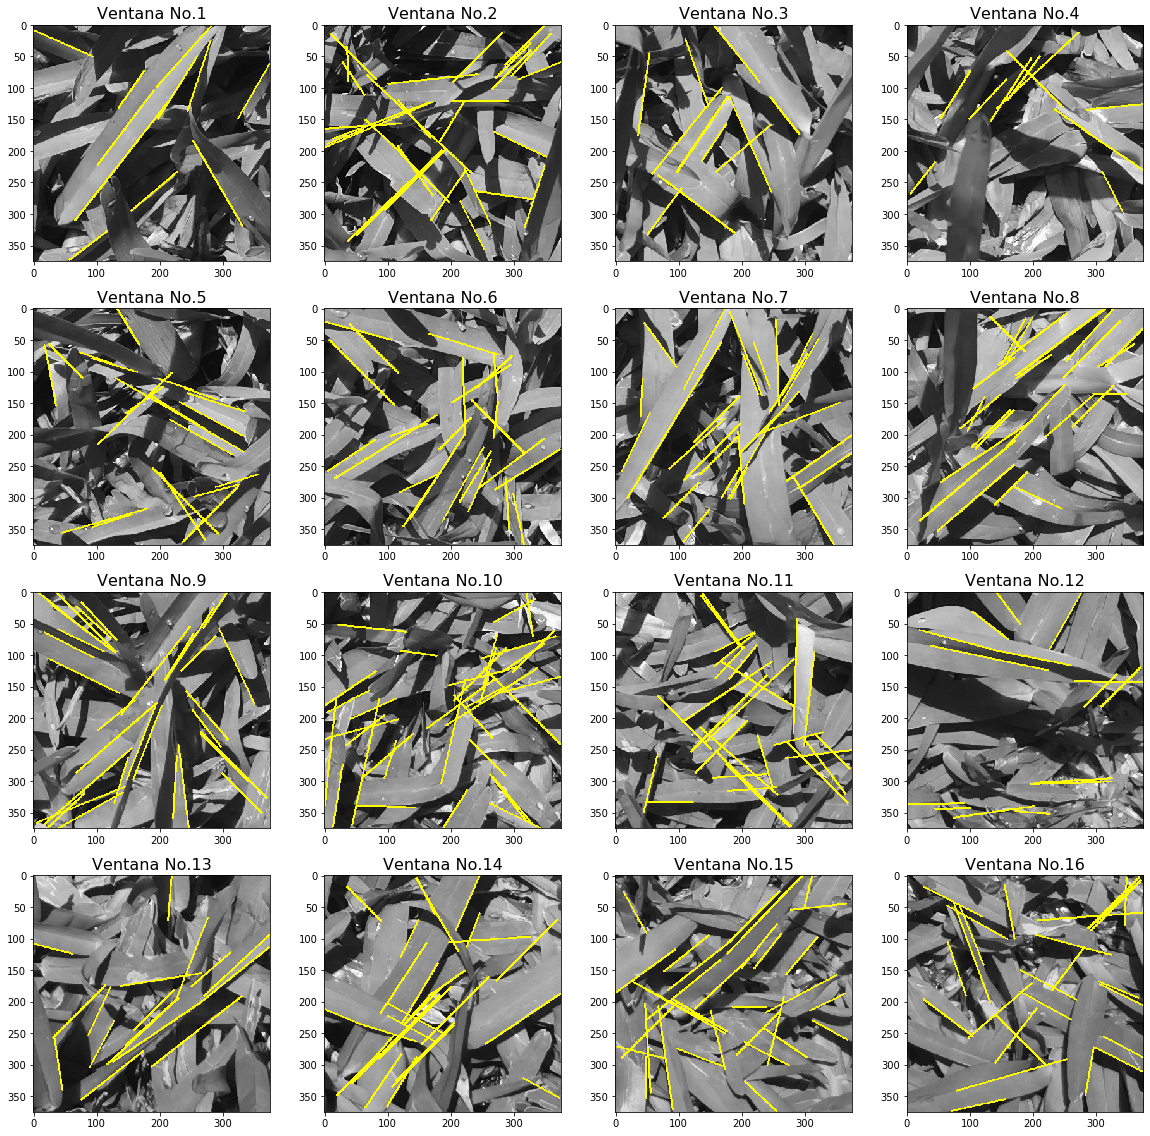

In [173]:
# Función de Estimación de Tallos Casa
tallos=tallos_grama(path,16,0.16,10)

### Campo de Golf

El número de hojas estimado es de: 192
La densidad de hojas estimada es de: 1200.0
El número de hojas en el campo estimado es de: 360000000.0


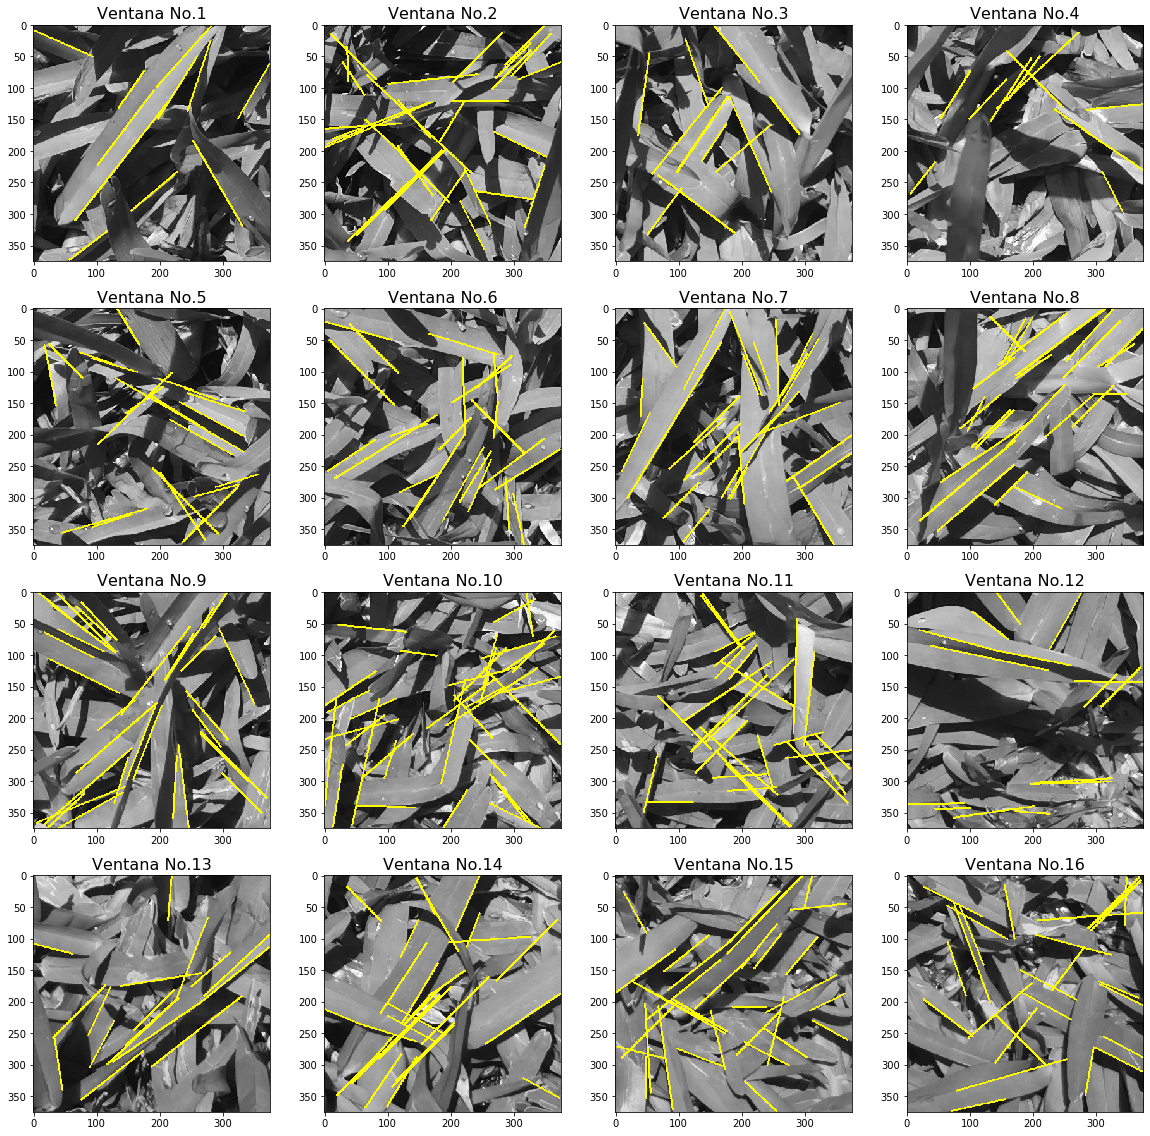

In [174]:
# Función de Estimación de Tallos Campo de Golf de 30 Héctareas (medida estándar de grama mantenida fuente Wikipedia)
tallos=tallos_grama(path,16,0.16,300000)